# Getting your hands dirty with LDA (Using the Foursquare API)

First things first, we want to develop a classifier that can detect if a user comment is misapplied to the venue. Think of all the times you've gone to an Amazon item and saw reviews that looked like the image below, "Used but in very good condition", "fast shipping" are these relevant to a product review? Or are they more appropriate for seller reviews? 

We're going to see if we can develop a comment classifier to detect which kinds of comments may be more appropriate for which venue type, and thus provide some indication on the "appropriateness" of the comment that can be used for further review, thus (we hope), improving the overall quality of Foursquare as a reviews platform

As an example: "This place got me drunk" would be a comment you'd expect to see for a store category "bar" 
Yet, "I want to have my wedding here" is definitely not a comment you'd expect to see at a "bar" category, more likely you'd see such a category associated with a park, or other such venue. 

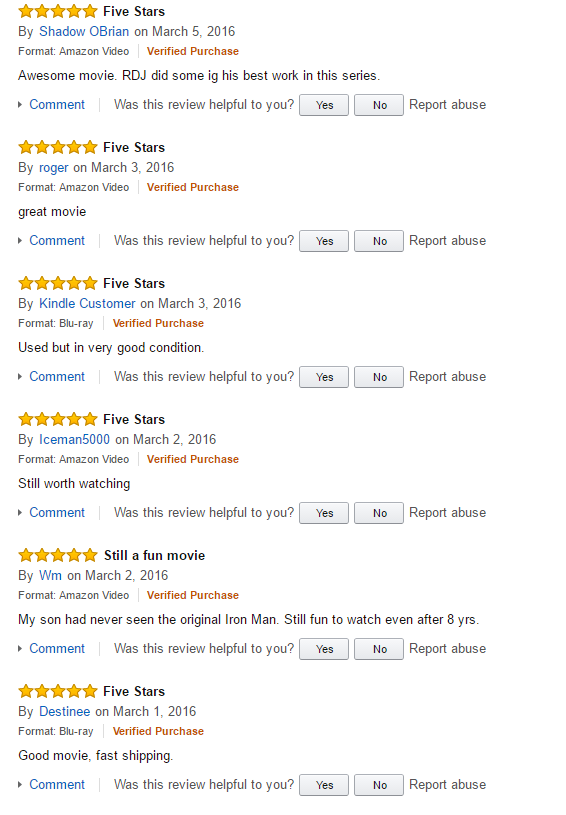

In [82]:
from IPython.display import Image
Image('F:/test/Bad Amazon Reviews.PNG')

Use the previously built table-creator on a few categories of Foursquare venues. 

Find the category list code in the following page: https://developer.foursquare.com/categorytree

In [49]:
import foursquare
import json
import pandas as pd
import unicodedata

CLIENT_ID = 'KP2002GUK1OHTDGWZ0COM20J1SEPMTTHLFCMRBEWFD0CZQXL'
CLIENT_SECRET = 'BT0MOOBYZZF1ANRZAM3LJYISWZQMA1E22OBBAEIHF24MYCY1'
client = foursquare.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

starting_list = client.venues.search(params={'near': 'Seattle, WA', 'radius':'3000','limit':50 })
print(json.dumps(starting_list, indent = 4))

Load all of your venues into a dataframe. Make sure that you have at least 4-6 categories of venues included in your data so we can seperate them out later with LDA.

In [44]:
df = pd.DataFrame(starting_list['venues'])
df

,allowMenuUrlEdit,beenHere,categories,contact,hasMenu,hasPerk,hereNow,id,location,menu,name,referralId,specials,stats,storeId,url,venueChains,venuePage,venueRatingBlacklisted,verified
0,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Offices', u'primary': True,...",{u'twitter': u'PitchBook'},NaN,False,"{u'count': 1, u'groups': [{u'count': 1, u'item...",4d5435bab3d9a35d2513cb7b,"{u'city': u'Seattle', u'labeledLatLngs': [{u'l...",NaN,PitchBook,v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 0, u'checkinsCount': 1409, u'use...",NaN,NaN,[],NaN,True,False
1,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Libraries', u'primary': Tru...",{u'facebookName': u'The Seattle Public Library...,NaN,False,"{u'count': 1, u'groups': [{u'count': 1, u'item...",42a78680f964a52011251fe3,"{u'city': u'Seattle', u'cc': u'US', u'country'...",NaN,Seattle Public Library (Seattle Central Library),v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 142, u'checkinsCount': 24936, u'...",NaN,http://www.spl.org/locations/central-library,[],{u'id': u'78244976'},True,True
2,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Neighborhoods', u'primary':...","{u'facebookName': u'Downtown Seattle', u'twitt...",NaN,False,"{u'count': 2, u'groups': [{u'count': 2, u'item...",4c73334913228cfa364e2d65,"{u'city': u'Seattle', u'cc': u'US', u'country'...",NaN,Downtown Seattle,v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 39, u'checkinsCount': 63418, u'u...",NaN,http://www.downtownseattle.com,[],NaN,True,False
3,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Buildings', u'primary': Tru...",{},NaN,False,"{u'count': 0, u'groups': [], u'summary': u'Nob...",4ba67df6f964a520c25739e3,"{u'city': u'Seattle', u'labeledLatLngs': [{u'l...",NaN,901 Fifth Avenue Building,v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 0, u'checkinsCount': 1766, u'use...",NaN,NaN,[],NaN,True,False
4,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Parks', u'primary': True, u...",{},NaN,False,"{u'count': 0, u'groups': [], u'summary': u'Nob...",4c3a70261a38ef3b69229321,"{u'city': u'Seattle', u'labeledLatLngs': [{u'l...",NaN,Kurt Cobain Park,v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 0, u'checkinsCount': 115, u'user...",NaN,NaN,[],NaN,NaN,False
5,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...",[{u'pluralName': u'Residential Buildings (Apar...,{},NaN,False,"{u'count': 0, u'groups': [], u'summary': u'Nob...",54034b84498e97b4651704e9,"{u'city': u'Seattle', u'labeledLatLngs': [{u'l...",NaN,5th and Madison Condos,v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 0, u'checkinsCount': 16, u'users...",NaN,NaN,[],NaN,True,False
6,True,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Hotels', u'primary': True, ...",{u'facebookName': u'Renaissance Phoenix Downto...,NaN,False,"{u'count': 0, u'groups': [], u'summary': u'Nob...",49e39fa6f964a520a2621fe3,"{u'city': u'Seattle', u'labeledLatLngs': [{u'l...",NaN,Renaissance Seattle Hotel,v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 77, u'checkinsCount': 12540, u'u...",,http://www.renhotels.com/,[{u'id': u'556a2d9ea7c8957d73d4052a'}],NaN,NaN,True
7,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Cities', u'primary': True, ...","{u'facebookName': u'Seattle City Council', u't...",NaN,False,"{u'count': 1, u'groups': [{u'count': 1, u'item...",4c4e36c7d667d13aef800aa0,"{u'cc': u'US', u'country': u'United States', u...",NaN,City of Seattle,v-1480470439,"{u'count': 0, u'items': []}","{u'tipCount': 53, u'checkinsCount': 60983, u'u...",NaN,http://www.seattle.gov,[],NaN,True,False
8,NaN,"{u'unconfirmedCount': 0, u'marked': False, u'l...","[{u'pluralName': u'Coworking Spaces', u'primar...","{u'phone': u'2066211800', u'formattedPhone': u...",NaN,False,"{u'count': 0, u'groups': [], u'summary': u'Nob...",4b86cd31f964a5204b9e31

In [67]:
categories = []
catnames = []
for i in range(0,50):
    for j in df.categories[i]:
        categories.append(j['id'])
        catnames.append(j['pluralName'])

catsdf = pd.DataFrame()
catsdf['catid'] =  categories
catsdf['catnames'] =  catnames
catsdf.drop_duplicates()

,catid,catnames
0,4bf58dd8d48988d124941735,Offices
1,4bf58dd8d48988d12f941735,Libraries
2,4f2a25ac4b909258e854f55f,Neighborhoods
3,4bf58dd8d48988d130941735,Buildings
4,4bf58dd8d48988d163941735,Parks
5,4d954b06a243a5684965b473,Residential Buildings (Apartments / Condos)
6,4bf58dd8d48988d1fa931735,Hotels
7,50aa9e094b90af0d42d5de0d,Cities
8,4bf58dd8d48988d174941735,Coworking Spaces
9,4bf58dd8d48988d176941735,Gyms


In [95]:
#  4 categories from above dataframe - Parks, Hotels, Tech Startups and Electronics Stores
cats = ['4bf58dd8d48988d163941735', '4bf58dd8d48988d1fa931735', '4bf58dd8d48988d125941735', '4bf58dd8d48988d122951735']
ids = {}
ids ={}
for i in cats:
    Venues_list = client.venues.search(params={'limit':50, 'near': 'Seattle, WA', 'radius':'5000', 'categoryId': i})
    for j in range(len(art_list['venues'])):
        ids[Venues_list['venues'][j]['id']] = i
ids

{u'410ae100f964a520a60b1fe3': '4bf58dd8d48988d1fa931735',
 u'42e18880f964a52066261fe3': '4bf58dd8d48988d163941735',
 u'430bb880f964a5203a271fe3': '4bf58dd8d48988d163941735',
 u'4335e880f964a5201b281fe3': '4bf58dd8d48988d1fa931735',
 u'440b6aedf964a52078301fe3': '4bf58dd8d48988d1fa931735',
 u'44142dc1f964a520ec301fe3': '4bf58dd8d48988d163941735',
 u'441483eff964a520f1301fe3': '4bf58dd8d48988d163941735',
 u'444eabf8f964a52093321fe3': '4bf58dd8d48988d163941735',
 u'45431fd4f964a5205c3c1fe3': '4bf58dd8d48988d1fa931735',
 u'455864a4f964a520403d1fe3': '4bf58dd8d48988d1fa931735',
 u'4558a938f964a520493d1fe3': '4bf58dd8d48988d163941735',
 u'457945ebf964a520cc3e1fe3': '4bf58dd8d48988d1fa931735',
 u'45b9ffd5f964a520dd411fe3': '4bf58dd8d48988d1fa931735',
 u'46216e18f964a52093451fe3': '4bf58dd8d48988d1fa931735',
 u'4750942cf964a520b14c1fe3': '4bf58dd8d48988d1fa931735',
 u'475f1b85f964a520db4c1fe3': '4bf58dd8d48988d163941735',
 u'47bcecd0f964a520d74d1fe3': '4bf58dd8d48988d1fa931735',
 u'4884484bf96

In [106]:
comments = []
catids =[]
for k, v in ids.iteritems():
    tips_list = client.venues.tips(VENUE_ID= k, params = {'limit':100})
    for j in range(len(tips_list['tips']['items'])):
        comments.append(tips_list['tips']['items'][j]['text'])
        catids.append(v)

In [107]:
coms_df = pd.DataFrame({"comments" : comments, "category" : catids})

In [116]:
coms_df.category.value_counts()

4bf58dd8d48988d1fa931735    1519
4bf58dd8d48988d163941735     755
4bf58dd8d48988d122951735      84
4bf58dd8d48988d125941735      64
Name: category, dtype: int64

In [118]:
from sklearn.preprocessing import LabelEncoder


LE = LabelEncoder()
y = LE.fit_transform(coms_df['category'])

# Constructing features using string parsing and elementary text mining

Create a normalizer function that will take the comments, lowercase all uppercase letters, split each comment into an array/list/vector of words, and remove stop words. 

In [1]:
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3            
import numpy as np
from textblob import TextBlob

Write a normalizing method, one that will convert all letters in a string into lower case, and remove stopwords. 

Use the normalizer that you created to build a 'stripped' down comments array/vector/list (however you did it)

Vectorize your feature set into a dense matrix representation using Countvectorizer from sklearn

A helpful reference: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [149]:
from sklearn.feature_extraction.text import CountVectorizer

V = CountVectorizer(token_pattern='[a-zA-Z0-9]{3,50}',
                        ngram_range=(1, 2), 
#                         max_df=0.8, 
                        min_df=2,
                        stop_words='english')

X_v = V.fit_transform(coms_df['comments'])

cols = V.get_feature_names()
print len(cols)
X = pd.DataFrame(X_v.todense(), columns = cols)

3356


In [154]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_v.toarray(), y, test_size=0.3, random_state=42)

# Performing the LDA

Construct your LDA with the pieces above by fitting the model to your feature set and target

In [5]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=auto)

# LDA.fit(X_train, y_train)

# LDA.score(X_test, y_test)

In [169]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA = LinearDiscriminantAnalysis(solver='svd',tol=0.5, n_components=2)

LDA.fit(X_train, y_train)

LDA.score(X_test, y_test)

0.76478679504814306

In [186]:
LDA.explained_variance_ratio_

array([ 0.46694999,  0.33484689])

In [182]:
X_new = LDA.transform(X)

In [172]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = LDA.predict(X_test)
print confusion_matrix(y_test, y_pred)
print classification_report(y_test, y_pred)

[[  8   0   4  15]
 [  0   5   1   5]
 [  2   3 153  76]
 [  9   5  51 390]]
             precision    recall  f1-score   support

          0       0.42      0.30      0.35        27
          1       0.38      0.45      0.42        11
          2       0.73      0.65      0.69       234
          3       0.80      0.86      0.83       455

avg / total       0.76      0.76      0.76       727



# Visualizing Results

Now print the LDA and at least a few of the categories on a 2-D discriminant chart. Do you think the method is seperating the categories very well? Should we tune it more? Would it be a good indicator of "inappropriate commenting"? 

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

# This creates random colors for your categories!
r = lambda: random.randint(0,255)
rcolor = lambda: '#%02X%02X%02X' % (r(),r(),r())



In [183]:
for_the_plot = pd.concat([pd.DataFrame(X_new),pd.DataFrame(y)], axis=1)
for_the_plot.columns = ['c1', 'c2', 'y']

for_the_plot.dropna(inplace=True)

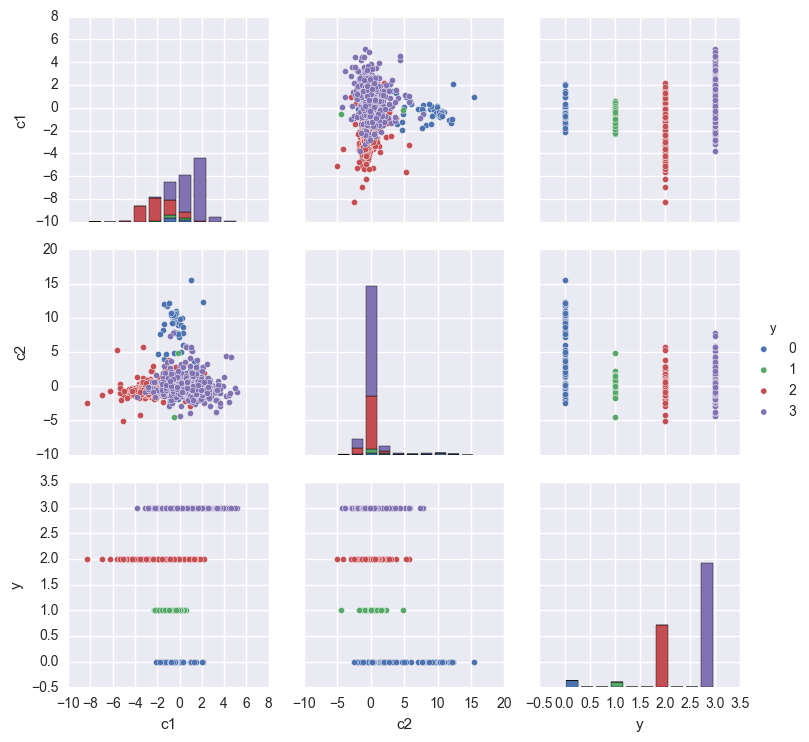

In [184]:
import seaborn as sns


sns.pairplot(for_the_plot, hue='y')